## Import

### Install Package

In [2]:
# !pip install imbalanced-learn

### Import package

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
import warnings
import time
import datetime
import pytz

## Define Variables

In [4]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/address_data_combined.csv"

In [5]:
warnings.filterwarnings("ignore")
desired_timezone = pytz.timezone('Asia/Ho_Chi_Minh')
plt.rcParams['figure.figsize'] = (11.0, 8.0)

## Load Data

In [6]:
df_combine = pd.read_csv(data_path)

In [7]:
df_combine.shape

(104788, 21)

In [10]:
df_combine.drop(columns=["total_eth_balance"], inplace=True)

In [11]:
df_combine.head()

,address,avg_sent_time,avg_received_time,time_difference_mins,sent,received,errors,unique_received_addresses,unique_sent_addresses,min_eth_received,max_eth_received,avg_eth_received,min_eth_sent,max_eth_sent,avg_eth_sent,avg_gas_fee,total_txs,total_eth_sent,total_eth_received,flag
0,0x6c96769a08ddefa92e06de0a32089272c57f79b2,32.464093,0.0,173455.65,5343,0,1238,0,3,0.0,0.0,0.0,0.0,2.984179,0.000559,0.006758,5343,2.984179,0.0,1
1,0x73f858acd93866902f59a8b53ab5f8ae1824c74b,32.079906,0.0,173456.05,5407,0,1253,0,3,0.0,0.0,0.0,0.0,2.697222,0.000499,0.006526,5407,2.697222,0.0,1
2,0x8dab36ee57328e700380d1fd6588bc3de5fe8ec3,32.210966,0.0,173456.05,5385,0,1298,0,3,0.0,0.0,0.0,0.0,3.572697,0.000663,0.006141,5385,3.572697,0.0,1
3,0xc9c736bab11d24528c3543b14e610e5c6a30d921,57.475760,0.0,417906.25,7271,0,57,0,10,0.0,0.0,0.0,0.0,14.000000,0.005501,0.032492,7271,40.000000,0.0,1
4,0xd74e2d68510786311f05a898ea6fa7a36727ee55,32.476325,0.0,173456.05,5341,0,1263,0,3,0.0,0.0,0.0,0.0,2.698424,0.000505,0.006419,5341,2.698424,0.0,1


In [12]:
df_combine.shape

(104788, 20)

In [13]:
f_txn = len(df_combine[df_combine['flag'] == 0])
print('current amount of fraud is now ', f_txn, ' which is ', (f_txn/len(df_combine))*100, ' % of the original dataset')

current amount of fraud is now  10643  which is  10.156697331755545  % of the original dataset


In [14]:
df_combine.nunique()

address                      104784
avg_sent_time                 79371
avg_received_time             66949
time_difference_mins          80202
sent                           3721
received                       1361
errors                          841
unique_received_addresses       709
unique_sent_addresses          1610
min_eth_received              46069
max_eth_received              50904
avg_eth_received              66256
min_eth_sent                  27087
max_eth_sent                  57417
avg_eth_sent                  83312
avg_gas_fee                   83641
total_txs                      3790
total_eth_sent                81968
total_eth_received            65437
flag                              2
dtype: int64

In [15]:
df_ert = df_combine.select_dtypes(include='number')

df_ert.shape

(104788, 19)

## Split Data

In [16]:
X = df_ert.drop('flag',axis=1)
print(X.shape)
y = df_ert ['flag'] # y_column needs to be 1d
print(y.shape)

(104788, 18)
(104788,)


In [17]:
columns = X.columns.to_list()

In [18]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,train_size=0.7,random_state=42)
X_train_full.shape, X_test.shape, y_train_full.shape, y_test.shape

((73351, 18), (31437, 18), (73351,), (31437,))

In [19]:
scaler = MinMaxScaler()

In [20]:
# Log transformation for skewed data and scaling
for c in columns:
    # Log transformation
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling using only the training data to avoid data leakage
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test)

In [21]:
np.isnan(X_train_full_scaled).any()

False

In [22]:
X_train_full_scaled.shape

(73351, 18)

In [23]:
X_train_full.head()

,avg_sent_time,avg_received_time,time_difference_mins,sent,received,errors,unique_received_addresses,unique_sent_addresses,min_eth_received,max_eth_received,avg_eth_received,min_eth_sent,max_eth_sent,avg_eth_sent,avg_gas_fee,total_txs,total_eth_sent,total_eth_received
95867,0.978326,9.176063,11.255779,2.079442,2.079442,0.000000,0.000000,0.000000,-2.708991,-2.071124,-2.308734,-2.715317,-2.074462,-2.312969,-7.775256,2.772589,-0.233528,-0.229293
45488,8.107128,0.000000,9.205740,1.098612,0.000000,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.077854,1.098612,0.000000,0.000000
14554,6.501175,7.522540,12.896365,6.107023,3.988984,3.044522,2.772589,4.356709,-7.976683,0.181443,-1.565174,0.000000,0.336472,-2.383633,-6.215978,6.220590,3.723390,2.423810
38774,1.208960,0.000000,1.902108,0.693147,0.000000,0.000000,0.000000,0.693147,-4.337895,-4.337895,-4.337895,0.000000,-4.479538,-5.172685,-7.055475,1.098612,-4.479538,-4.337895
61195,6.173628,6.372228,11.134775,4.890349,2.079442,2.890372,0.000000,4.615121,-3.506558,-2.302585,-2.686411,0.000000,-2.322515,-6.543704,-5.558093,4.948760,-1.653355,-0.606969


In [24]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_full_scaled, y_train_full)

In [25]:
X_test, y_test = smote.fit_resample(X_test_full_scaled, y_test)

## Config Model

In [26]:
et = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 10)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [27]:
grid_search = GridSearchCV(estimator=et,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1,
                           verbose=1,
                           scoring="f1")

## Evualution Model

In [28]:
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4,
             estimator=ExtraTreesClassifier(criterion='entropy',
                                            max_features=10, n_estimators=5),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [29]:
grid_search.best_params_

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}

In [30]:
grid_search.best_score_

0.98969265054092

In [31]:
et_best = grid_search.best_estimator_
et_best

ExtraTreesClassifier(criterion='entropy', max_depth=20, max_features=10,
                     min_samples_leaf=5)

In [32]:
plt.figure(figsize=(50,50))
plot_tree(et_best.estimators_[5], feature_names=X.columns, class_names=['Fraud', "No Fraud"], filled=True, proportion=True, rounded=True, precision=2)
plt.savefig("tree.eps")

Output hidden; open in https://colab.research.google.com to view.

## Ranking Feature

In [35]:
et_best.fit(X_train,y_train)
y_pred = et_best.predict(X_test)
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))

0.9851241419470962
0.9850780613870499
0.9881757354763337
0.9850780613870499
0.9820913376961509


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     28247
           1       0.98      0.99      0.99     28247

    accuracy                           0.99     56494
   macro avg       0.99      0.99      0.99     56494
weighted avg       0.99      0.99      0.99     56494



In [37]:
feature_importances = et_best.feature_importances_

feature_imp_df = pd.DataFrame({
    "Features" : X_train_full.columns,
    "Importance" : feature_importances
})
feature_imp_df.sort_values(by="Importance",ascending=False)

,Features,Importance
0,avg_sent_time,0.178852
3,sent,0.151177
2,time_difference_mins,0.144298
1,avg_received_time,0.129832
15,total_txs,0.100273
14,avg_gas_fee,0.064445
7,unique_sent_addresses,0.042121
4,received,0.041575
6,unique_received_addresses,0.036356
17,total_eth_received,0.016874


In [38]:
current = datetime.datetime.now()
current_time_with_timezone = current.astimezone(desired_timezone)
formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")
feature_imp_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Dataset/{formatted_date}_feature_imp.csv", index=False)

In [39]:
feature_imp_df.sort_values(by="Importance",ascending=False).head(20)

,Features,Importance
0,avg_sent_time,0.178852
3,sent,0.151177
2,time_difference_mins,0.144298
1,avg_received_time,0.129832
15,total_txs,0.100273
14,avg_gas_fee,0.064445
7,unique_sent_addresses,0.042121
4,received,0.041575
6,unique_received_addresses,0.036356
17,total_eth_received,0.016874


In [40]:
feature_imp_df.sort_values(by="Importance",ascending=False)

,Features,Importance
0,avg_sent_time,0.178852
3,sent,0.151177
2,time_difference_mins,0.144298
1,avg_received_time,0.129832
15,total_txs,0.100273
14,avg_gas_fee,0.064445
7,unique_sent_addresses,0.042121
4,received,0.041575
6,unique_received_addresses,0.036356
17,total_eth_received,0.016874


In [44]:
top_10_features = feature_imp_df.sort_values(by="Importance", ascending=False).head(10)["Features"].tolist()

In [45]:
top_10_features

['avg_sent_time',
 'sent',
 'time_difference_mins',
 'avg_received_time',
 'total_txs',
 'avg_gas_fee',
 'unique_sent_addresses',
 'received',
 'unique_received_addresses',
 'total_eth_received']

In [41]:
# Sắp xếp DataFrame theo cột "Importance" theo thứ tự giảm dần và lấy 11 dòng đầu tiên
top_features_df = feature_imp_df.sort_values(by="Importance", ascending=False).head(11)

# Lấy tên các feature từ cột "Feature" của DataFrame và lưu vào danh sách
top_features_list = top_features_df["Features"].tolist()

# In ra danh sách các feature
print(top_features_list)


['avg_sent_time', 'sent', 'time_difference_mins', 'avg_received_time', 'total_txs', 'avg_gas_fee', 'unique_sent_addresses', 'received', 'unique_received_addresses', 'total_eth_received', 'total_eth_sent']


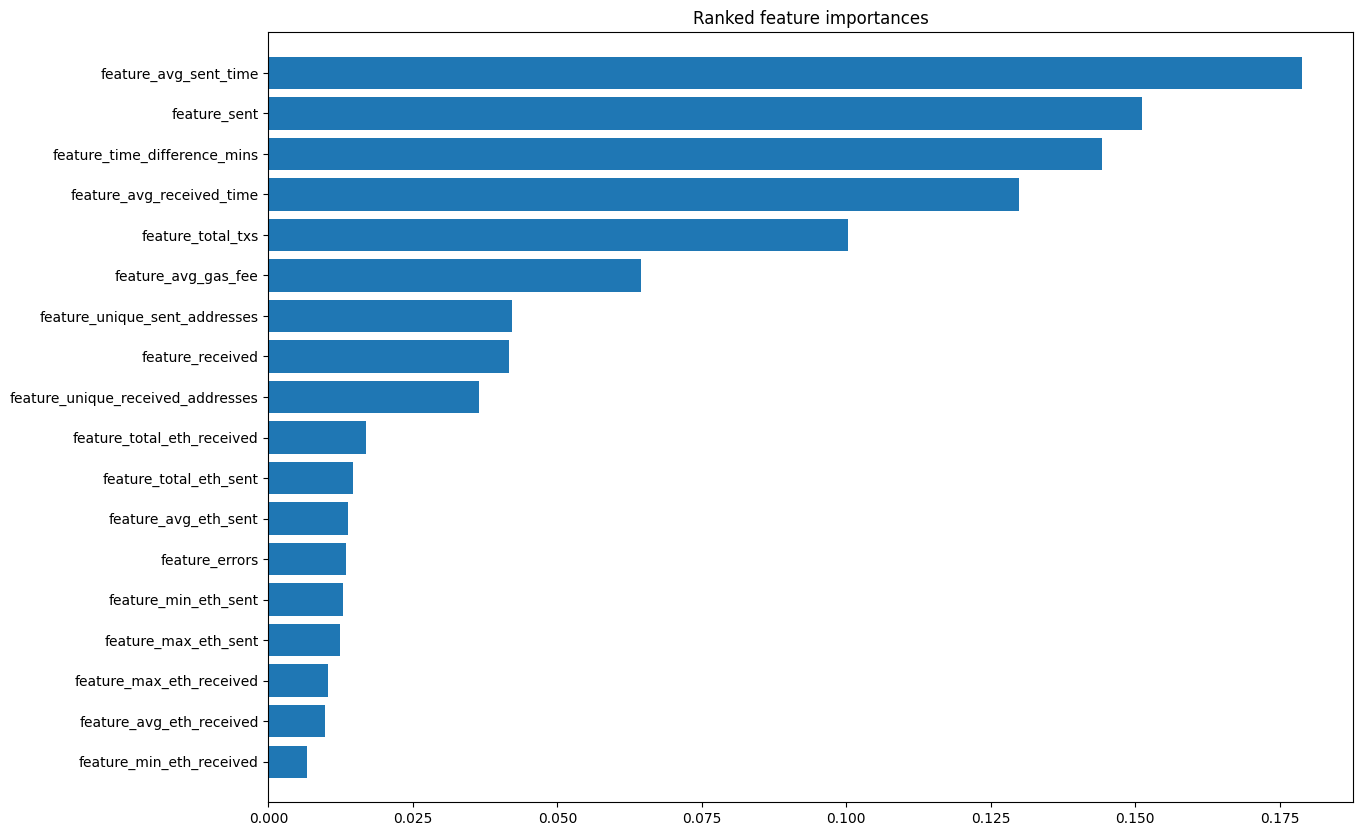

In [52]:
feat_importances = et_best.feature_importances_
indices = np.argsort(feat_importances)
# plot
columns = np.array(X_train_full.columns)
fig, ax = plt.subplots(figsize=(14, 10))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])

current = datetime.datetime.now()
current_time_with_timezone = current.astimezone(desired_timezone)
formatted_date = current_time_with_timezone.strftime("%Y-%m-%d_%H-%M-%S")
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/Dataset/{formatted_date}_feature_imp.png")

plt.show()